# Player Performance Prediction: Time Series Analysis  

# Intro
In the previous section, we predict daily performance using weighted average, and used multi-profit 0/1 knapsack to build the 13 man roster.  

Now I want to focus on improving my prediction of daily performance using Time Series Analysis.  
We first perform simple *OLS regression* to predict daily performance.  
Then we start performing time series analysis that breaks into a few parts:  
- Trend (time dependence)
- Seasonality (time dependence)
- Cycles (serial dependence)
- Hybrid



# 1. Data Scraping and Preprocessing

Let's Create the time series data for every single player.  
We will use the "player box score" data.  
We used years 2021~2024 for the weighted average prediction in the previous section.  
It's only reasonable to also use 2021~2024 for our time series data to compare the method's performance.  

Let's first get 2021~2023 player box score and save it as pbs2021.csv ~ pbs2023.csv  
We will deal with the current 2024 season later. 


In [72]:
# Use basketball_reference_web_scraper package.  https://jaebradley.github.io/basketball_reference_web_scraper/  
from basketball_reference_web_scraper import client
import pandas as pd
import time
import requests
import datetime
import os

In [73]:
season_start_end_Dates = {
    '2021': 
    {'start_date': datetime.date(2020, 12, 22), 
    'end_date': datetime.date(2021, 5, 16)}, 
    '2022':
    {'start_date': datetime.date(2021, 10, 19), 
    'end_date': datetime.date(2022, 4, 10)},
    '2023':
    {'start_date': datetime.date(2022, 10, 18), 
    'end_date': datetime.date(2023, 4, 9)},
    '2024':
    {'start_date': datetime.date(2023, 10, 24), 
    'end_date': min(datetime.date(2023, 4, 14), datetime.date.today())}
}

df_pbs = {}
for yr in range(2021, 2024): # 2021~2023
    if f'pbs{yr}.csv' in os.listdir():
        df_pbs[str(yr)] = pd.read_csv(f'pbs{yr}.csv', index_col=0, parse_dates=['date']) 
    else:
        date = season_start_end_Dates[str(yr)]['start_date']
        enddate = season_start_end_Dates[str(yr)]['end_date']
        while date <= enddate: 
            try: 
                df_tmp = pd.DataFrame.from_dict(client.player_box_scores(day=date.day, month=date.month, year=date.year))
            except requests.exceptions.HTTPError as err:
                print(f'A HTTPError was thrown: {err.code} {err.reason}')
                df_pbs[str(yr)].to_csv(f'pbs{str(yr)}.csv')

            df_tmp['date'] = date
            if str(yr) not in df_pbs:
                df_pbs[str(yr)] = df_tmp
            else: 
                df_pbs[str(yr)] = pd.concat([df_pbs[str(yr)], df_tmp])
            date = date + datetime.timedelta(1)
            time.sleep(15) # delay for 5 seconds. sometimes you'll need 20 seconds

        df_pbs[str(yr)].to_csv(f'pbs{str(yr)}.csv')

df_pbs['2021'].head()

,slug,name,team,location,opponent,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,...,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,game_score,date
0,georgpa01,Paul George,Team.LOS_ANGELES_CLIPPERS,Location.AWAY,Team.LOS_ANGELES_LAKERS,Outcome.WIN,2146.0,13.0,18.0,5.0,...,2.0,0.0,6.0,3.0,1.0,0.0,5.0,3.0,24.3,2020-12-22
1,irvinky01,Kyrie Irving,Team.BROOKLYN_NETS,Location.HOME,Team.GOLDEN_STATE_WARRIORS,Outcome.WIN,1518.0,10.0,16.0,4.0,...,2.0,1.0,3.0,4.0,0.0,0.0,1.0,3.0,21.0,2020-12-22
2,harremo01,Montrezl Harrell,Team.LOS_ANGELES_LAKERS,Location.HOME,Team.LOS_ANGELES_CLIPPERS,Outcome.LOSS,1935.0,6.0,7.0,0.0,...,7.0,4.0,6.0,3.0,0.0,1.0,1.0,1.0,19.7,2020-12-22
3,duranke01,Kevin Durant,Team.BROOKLYN_NETS,Location.HOME,Team.GOLDEN_STATE_WARRIORS,Outcome.WIN,1496.0,7.0,16.0,1.0,...,7.0,1.0,4.0,3.0,3.0,1.0,1.0,3.0,19.1,2020-12-22
4,leverca01,Caris LeVert,Team.BROOKLYN_NETS,Location.HOME,Team.GOLDEN_STATE_WARRIORS,Outcome.WIN,1489.0,6.0,17.0,3.0,...,6.0,1.0,8.0,5.0,2.0,1.0,2.0,1.0,17.0,2020-12-22


Now let's get the current up-to-date player box score for this season (2023-2024)

In [74]:
date = season_start_end_Dates['2024']['start_date']
enddate = season_start_end_Dates['2024']['end_date']
if 'pbs2024.csv' in os.listdir():
    df_pbs['2024'] = pd.read_csv(f'pbs2024.csv', index_col=0, parse_dates=['date'])
    date = df_pbs['2024']['date'].max()

while date <= enddate: 
    try: 
        df_tmp = pd.DataFrame.from_dict(client.player_box_scores(day=date.day, month=date.month, year=date.year))
    except requests.exceptions.HTTPError as err:
        print(f'A HTTPError was thrown: {err}')
        df_pbs['2024'].to_csv(f'pbs2024.csv')

    df_tmp['date'] = date
    if '2024' not in df_pbs:
        df_pbs['2024'] = df_tmp
    else: 
        df_pbs['2024'] = pd.concat([df_pbs['2024'], df_tmp])
    date = date + datetime.timedelta(1)
    print(f'{date} finished')
    time.sleep(10) # delay for 5 seconds. sometimes you'll need 20 seconds

df_pbs['2024'].to_csv(f'pbs2024.csv')

c:\Users\joe_c\miniconda3\envs\basketball\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  import sys


Preprocess some of the data into a more 9-cat friendly features.  

In [75]:
for yr in range(2021, 2025):
    df_pbs[str(yr)]['pts'] = df_pbs[str(yr)]['made_free_throws'] + df_pbs[str(yr)]['made_three_point_field_goals']*3 + (df_pbs[str(yr)]['made_field_goals']-df_pbs[str(yr)]['made_three_point_field_goals'])*2
    df_pbs[str(yr)]['FGperc'] = df_pbs[str(yr)]['made_field_goals'] / df_pbs[str(yr)]['attempted_field_goals']
    df_pbs[str(yr)]['FTperc'] = df_pbs[str(yr)]['made_free_throws'] / df_pbs[str(yr)]['attempted_free_throws']
    df_pbs[str(yr)]['rebs'] = df_pbs[str(yr)]['offensive_rebounds'] + df_pbs[str(yr)]['defensive_rebounds']

df_pbs['2024'].head()

,slug,name,team,location,opponent,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,...,steals,blocks,turnovers,personal_fouls,game_score,date,pts,FGperc,FTperc,rebs
0,jokicni01,Nikola Jokić,Team.DENVER_NUGGETS,Location.HOME,Team.LOS_ANGELES_LAKERS,Outcome.WIN,2176.0,12.0,22.0,3.0,...,1.0,1.0,2.0,2.0,29.3,2023-10-24,29.0,0.545455,0.5,13.0
1,bookede01,Devin Booker,Team.PHOENIX_SUNS,Location.AWAY,Team.GOLDEN_STATE_WARRIORS,Outcome.WIN,2218.0,13.0,21.0,3.0,...,1.0,0.0,6.0,4.0,23.7,2023-10-24,32.0,0.619048,1.0,6.0
2,jamesle01,LeBron James,Team.LOS_ANGELES_LAKERS,Location.AWAY,Team.DENVER_NUGGETS,Outcome.LOSS,1740.0,10.0,16.0,1.0,...,1.0,0.0,0.0,1.0,20.3,2023-10-24,21.0,0.625000,0.0,8.0
3,gordoaa01,Aaron Gordon,Team.DENVER_NUGGETS,Location.HOME,Team.LOS_ANGELES_LAKERS,Outcome.WIN,2099.0,7.0,11.0,1.0,...,2.0,1.0,0.0,0.0,19.2,2023-10-24,15.0,0.636364,NaN,7.0
4,murraja01,Jamal Murray,Team.DENVER_NUGGETS,Location.HOME,Team.LOS_ANGELES_LAKERS,Outcome.WIN,2055.0,8.0,13.0,3.0,...,0.0,1.0,1.0,3.0,18.4,2023-10-24,21.0,0.615385,1.0,2.0


# 2. Time Series Analysis

0. OLS regression
1. Trend (time dependence)
2. Seasonality (time dependence)
3. Cycles (serial dependence)
4. Hybrid

We will first try single player performance prediction.  
"Tyrese Haliburton" for example.  

**0. OLS Regression**  
We will use "lag features" to model our OLS regression.  
This lag features let us model "serial dependence" rather than time dependence.  

Get player Tyrese Haliburton's data from 2021~2024.  

In [76]:
name0='Tyrese Haliburton'
df_name0 = None
for yr in range(2021, 2025):
    if df_name0 is None:
        df_name0 = df_pbs[str(yr)][df_pbs[str(yr)]['name']==name0]
    else:
        df_name0 = pd.concat([df_name0, df_pbs[str(yr)][df_pbs[str(yr)]['name']==name0]])
df_name0.sort_values(by='date', ascending=True)
df_name0.head()

,slug,name,team,location,opponent,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,...,steals,blocks,turnovers,personal_fouls,game_score,date,pts,FGperc,FTperc,rebs
58,halibty01,Tyrese Haliburton,Team.SACRAMENTO_KINGS,Location.AWAY,Team.DENVER_NUGGETS,Outcome.WIN,1800.0,3.0,7.0,2.0,...,0.0,1.0,0.0,0.0,12.8,2020-12-23,12.0,0.428571,1.0,2.0
156,halibty01,Tyrese Haliburton,Team.SACRAMENTO_KINGS,Location.HOME,Team.PHOENIX_SUNS,Outcome.WIN,1569.0,1.0,4.0,0.0,...,0.0,1.0,1.0,2.0,2.6,2020-12-26,2.0,0.250000,NaN,2.0
30,halibty01,Tyrese Haliburton,Team.SACRAMENTO_KINGS,Location.HOME,Team.PHOENIX_SUNS,Outcome.LOSS,1592.0,5.0,7.0,3.0,...,0.0,0.0,0.0,2.0,16.2,2020-12-27,15.0,0.714286,1.0,1.0
30,halibty01,Tyrese Haliburton,Team.SACRAMENTO_KINGS,Location.HOME,Team.DENVER_NUGGETS,Outcome.WIN,1494.0,5.0,7.0,3.0,...,3.0,0.0,2.0,1.0,16.2,2020-12-29,13.0,0.714286,NaN,3.0
66,halibty01,Tyrese Haliburton,Team.SACRAMENTO_KINGS,Location.AWAY,Team.HOUSTON_ROCKETS,Outcome.LOSS,1603.0,4.0,9.0,2.0,...,2.0,0.0,1.0,2.0,7.4,2020-12-31,11.0,0.444444,0.5,2.0


Add Time Dummy

In [77]:
import numpy as np
df_name0['time'] = np.arange(len(df_name0.index))

Set the independent variable X = value of previous day,  
and the dependent variable y = value of current day.  

In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
df_tmp = df_name0.copy()
df_tmp['pts_lag1'] = df_tmp['pts'].shift(1)

# drop rows with pts_lag1==NaN
df_tmp = df_tmp[~df_tmp['pts_lag1'].isna()][['pts', 'pts_lag1']]
X = df_tmp[['pts_lag1']]
y = df_tmp[['pts']]

df_tmp

,pts,pts_lag1
156,2.0,12.0
30,15.0,2.0
30,13.0,15.0
66,11.0,13.0
17,17.0,11.0
...,...,...
3,21.0,33.0
2,22.0,21.0
4,26.0,22.0
0,31.0,26.0


Split the data into Training set and Testing set.  

In [80]:
train_size = int(len(df_tmp) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

Train

In [81]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

Test

In [82]:
test_idx = test_X.index
y_pred = pd.Series(model.predict(test_X).flatten(), index=test_idx)
y_pred

21     17.540123
22     17.007000
0      16.740438
27     23.404482
24     18.073247
2      16.207315
2      19.672617
0      18.606370
161    20.738864
0      15.141068
4      21.805111
16     20.738864
3      18.872932
1      20.738864
1      23.671043
0      18.872932
17     19.139494
8      17.273562
21     17.540123
22     17.007000
0      16.740438
27     23.404482
24     18.073247
2      16.207315
2      19.672617
0      18.606370
161    20.738864
0      15.141068
4      21.805111
16     20.738864
3      18.872932
1      20.738864
1      23.671043
0      18.872932
2      19.139494
60     17.273562
35     15.674191
44     17.806685
146    17.007000
22     14.074821
54     17.007000
6      16.473876
5      19.672617
3      20.738864
2      17.540123
4      17.806685
0      18.872932
0      20.205741
dtype: float64

Plot whole data trend with the predicted data ontop in a different color.  

In [83]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, "Time Plot of Tyrese Haliburton in 'points' ")

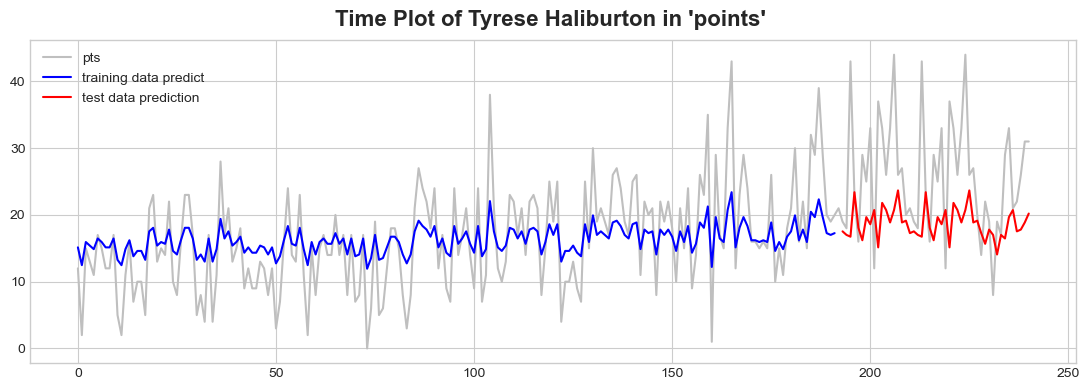

In [84]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
category = 'pts'

train_idx = df_name0.iloc[:train_size].index
ytrain_pred = pd.Series(model.predict(train_X).flatten(), index=train_idx)

fig, ax = plt.subplots()
ax.plot('time', category, data=df_name0, color='0.75')
ax.plot(df_name0.iloc[:train_size]['time'], ytrain_pred, color='blue', label="training data predict")
ax.plot(df_name0.iloc[train_size+1:]['time'], y_pred, color='red', label="test data prediction")
ax.legend()
ax.set_title(f'Time Plot of {name0} in \'points\' ')

Although the shape seems somehow reasonable, the model is mostly underestimating high points of Haliburton and overestimating the low points of Haliburton.  
It has a "conservative" guess of the points of Tyrese Haliburton.  
Can we improve?  

Next, utilize even more common time series analysis techniques regarding "time dependence": Trend, Seasonality.  
First we deal with "trend".  

**1. Trend**

In [85]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df_name0.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
58,1.0,1.0
156,1.0,2.0
30,1.0,3.0
30,1.0,4.0
66,1.0,5.0


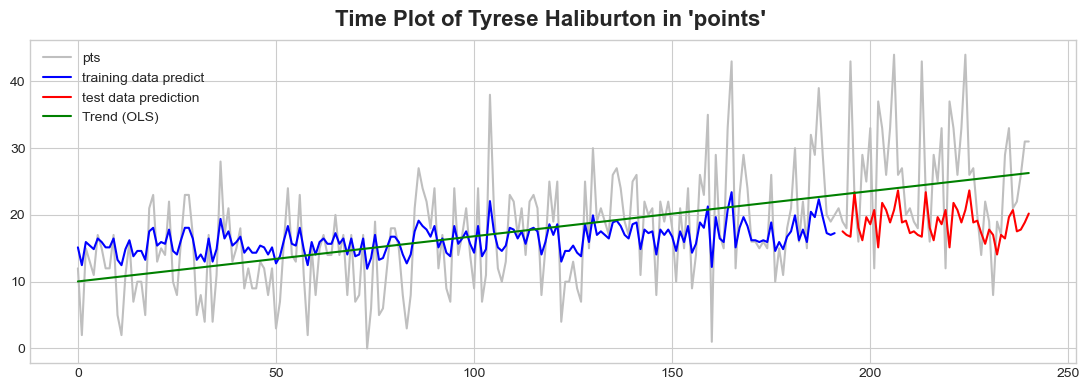

In [86]:
from sklearn.linear_model import LinearRegression

y = df_name0[category]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)
ax.plot(df_name0['time'], y_pred, color='green', label="Trend (OLS)")
ax.legend()
display(fig)

The overall trend of Tyrese Haliburton's points is increasing.  

Another way of analyzing the trend is using moving average by using the pandas rolling window function.  

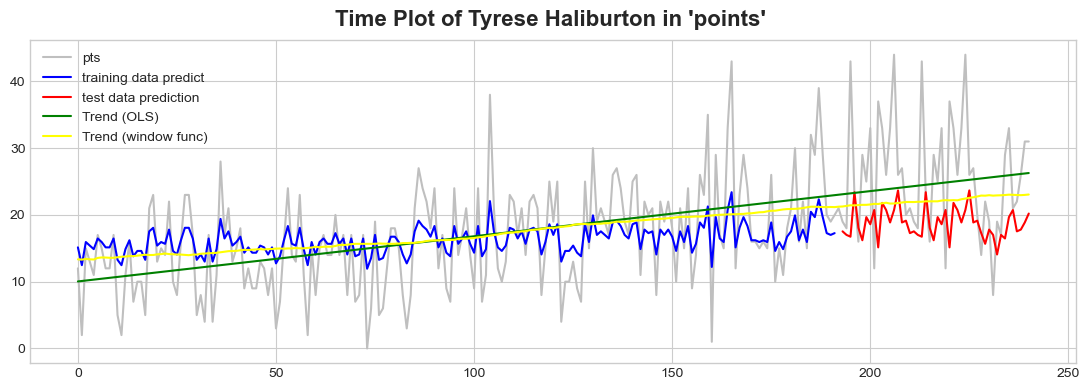

In [87]:
trend = df_name0[category].rolling(window=200, center=True, min_periods=100).mean()
ax.plot(df_name0['time'], trend, color='yellow', label="Trend (window func)")
ax.legend()
display(fig)

**2. Seasonality**  
Perform "Harmonic Regression": detect and model *seasonality* using Fourier Features and fast fourier transform.  

- Generate the periodogram of the time series (using fast fourier transform). 
- Create fourier features according to the strong frequencies in the periodogram. 
- Add the fourier features to our dependent variables using DeterministicProcess.  
- Use Linear Regression (OLS) to model the seasonality.  

Top 3 frequencies (in a game period): 
26.77777777777778
4.819999999999999
2.5638297872340425


<AxesSubplot:title={'center':"Periodogram of Tyrese Haliburton's pts"}>

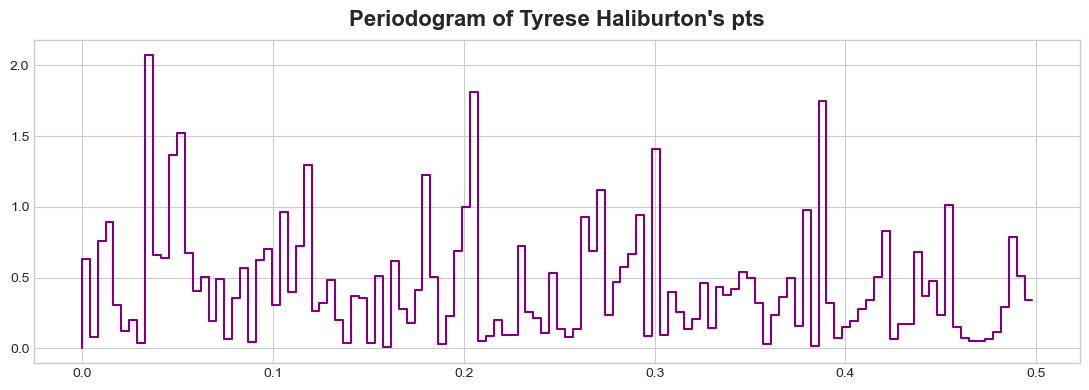

In [88]:
from scipy.signal import periodogram

ts = y
fs = 1 # len(ts) # sampling_freq

# Remember to detrend and apply windowing for better fft result. 
# The periodogram function uses Welch's method. 
f, psd = periodogram(
                        ts,
                        fs=fs, # (twosided) freqs = sp_fft.fftfreq(nfft, 1/fs)
                        detrend="linear",
                        window="boxcar",
                        scaling='spectrum', # scale = 1.0 / win.sum()**2
                    )

indexes = list(range(len(f)))
indexes.sort(key = lambda i: np.absolute(psd[i]))
indexes.reverse()
print(f"Top 3 frequencies (in a game period): ")
top3_freq = []
for i in indexes[:3]:
    top3_freq.append(1/f[i])
    print(f"{1/f[i]}")

_, ax = plt.subplots()
ax.step(f[f>=0], psd[f>=0], color="purple")
ax.set_title(f'Periodogram of {name0}\'s {category}')
ax

The top 3 frequencies are: 26, 18, 8  
Choose these 3 frequencies for our 3 fourier feature pairs. 

In [89]:
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

In [90]:
index = [i for i in range(len(y))]

# "order" amount of sin/cos Fourier pairs with a certain period.  
# 2 * order must be <= period 
# (period is the 1/freq of the trigonometric function)
fourier1 = Fourier(period=top3_freq[0], order=int(top3_freq[0]/2))  
print(f'fourier1: period={top3_freq[0]}, order={int(top3_freq[0]/2)}')
fourier2 = Fourier(period=top3_freq[1], order=int(top3_freq[1]/2))
print(f'fourier2: period={top3_freq[1]}, order={int(top3_freq[1]/2)}')
fourier3 = Fourier(period=top3_freq[2], order=int(top3_freq[2]/2))
print(f'fourier3: period={top3_freq[2]}, order={int(top3_freq[2]/2)}')
fourier = [fourier1, fourier2, fourier3]

# print(fourier.in_sample(index))

dp = DeterministicProcess(
    index=index, 
    constant=True, 
    order=1, 
    drop=True, 
    seasonal=False, 
    additional_terms=[*fourier]
)

Xsea = dp.in_sample()
print(Xsea.head())



fourier1: period=26.77777777777778, order=13
fourier2: period=4.819999999999999, order=2
fourier3: period=2.5638297872340425, order=1
   const  trend  sin(1,26.78)  cos(1,26.78)  sin(2,26.78)  cos(2,26.78)  \
0    1.0    1.0      0.000000      1.000000      0.000000      1.000000   
1    1.0    2.0      0.232495      0.972598      0.452247      0.891893   
2    1.0    3.0      0.452247      0.891893      0.806712      0.590945   
3    1.0    4.0      0.647215      0.762308      0.986754      0.162226   
4    1.0    5.0      0.806712      0.590945      0.953444     -0.301569   

   sin(3,26.78)  cos(3,26.78)  sin(4,26.78)  cos(4,26.78)  ...  sin(12,26.78)  \
0      0.000000      1.000000      0.000000      1.000000  ...       0.000000   
1      0.647215      0.762308      0.806712      0.590945  ...       0.320153   
2      0.986754      0.162226      0.953444     -0.301569  ...      -0.606605   
3      0.857205     -0.514976      0.320153     -0.947366  ...       0.829200   
4      0.3

Finally, let's use Linear Regression (OLS) to model the seasonality from the above.

In [91]:
train_size = int(len(df_tmp) * 0.8)
train_Xsea, test_Xsea = Xsea[:train_size], Xsea[train_size:]
train_y, test_y = y[:train_size], y[train_size:]
model = LinearRegression(fit_intercept=False)
model.fit(train_Xsea, train_y)

LinearRegression(fit_intercept=False)

Test

In [92]:
test_idx = test_Xsea.index
ySea_pred = pd.Series(model.predict(test_Xsea).flatten(), index=test_idx)

ySea_pred

192    26.733417
193    22.452142
194    21.710339
195    24.616685
196    25.130140
197    26.456339
198    19.921178
199    18.440828
200    22.519172
201    23.498114
202    23.537955
203    19.224608
204    13.116997
205    21.334740
206    24.264611
207    19.162336
208    23.965067
209    15.036687
210    24.971930
211    25.379992
212    26.954440
213    23.668577
214    22.742362
215    27.301761
216    26.830676
217    23.735345
218    21.802945
219    23.652324
220    25.640044
221    30.624118
222    22.535981
223    25.795923
224    23.633928
225    22.982965
226    27.674195
227    19.359072
228    23.519851
229    22.768364
230    21.819523
231    21.457814
232    19.395477
233    21.691466
234    22.244781
235    26.264607
236    22.928481
237    21.778488
238    23.906727
239    30.990742
240    25.742315
dtype: float64

Plot

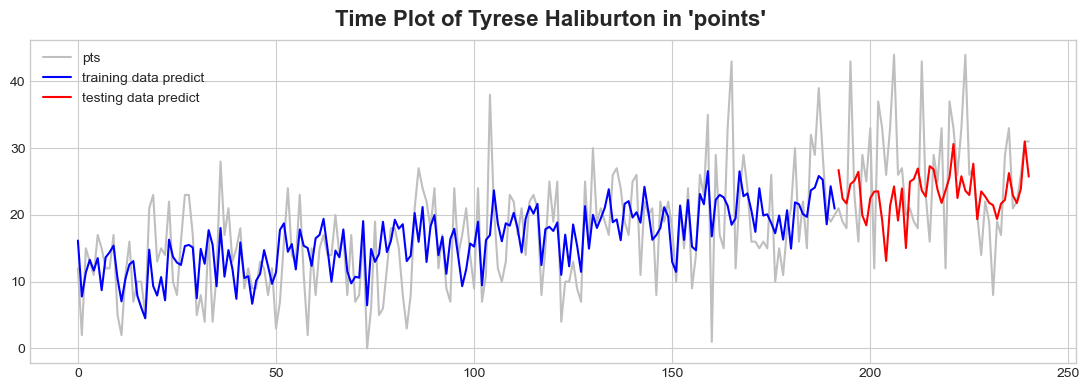

In [93]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
category = 'pts'


train_idx = train_Xsea.index
ySeatrain_pred = pd.Series(model.predict(train_Xsea).flatten(), index=train_idx)

fig, ax = plt.subplots()
ax.plot('time', category, data=df_name0, color='0.75')
ax.plot(df_name0.iloc[:train_size]['time'], ySeatrain_pred, color='blue', label="training data predict")
ax.plot(df_name0.iloc[train_size:]['time'], ySea_pred, color='red', label="testing data predict")
ax.set_title(f'Time Plot of {name0} in \'points\' ')
ax.legend()

The overall prediction seems better than the OLS regression model that only uses 1 lag feature.  
The points were less conservative than before.  And the prediction curve is much closer to the target curve.  
However, in the prediction there seems to be having some incorrect prediction between games 200~220  
Would having some serial dependence analysis on Cycles help?  
